In [1]:
import os
import numpy as np
import json

ROOT = "/home/mario/Python/Datasets/EEG/timeseries/processed/rqa_windows/"
OUTPUT = os.path.join(ROOT, "time_resolved_classification")
DATASET_ROOT = os.path.join(ROOT, "dataset")
DATASET_INDEXES = json.load(
    open(os.path.join(DATASET_ROOT, "dataset_index.json"), "r")
)
WINDOW = "window_200"
DIRECTION = "up"
ELECTRODE = "T7"

*Get fold indexes for patients*

In [2]:
from pyddeeg.classification.utils.strat_kfold import stratified_kfold

folds = stratified_kfold(root_path=DATASET_ROOT, n_splits=5, random_state=42, output_file=OUTPUT)
fold_index = 0
fold = folds.get("folds", [])[fold_index]
dd_train_index = fold.get("dd_train", [])
ct_train_index = fold.get("ct_train", [])
dd_test_index = fold.get("dd_test", [])
ct_test_index = fold.get("ct_test", [])

print(f"Fold {fold_index} - Train: {len(dd_train_index) + len(ct_train_index)} | Test: {len(dd_test_index) + len(ct_test_index)}")

Fold 0 - Train: 39 | Test: 10


*Create (for one electrode) the train and test dataset*

EEG Dataset Summary (Scikit-Learn Ready):
  Training data shape: (26481, 15)
  Testing data shape: (6790, 15)
  Training labels shape: (26481,)
  Testing labels shape: (6790,)
  Unique training labels: (array([0., 1.]), array([10185, 16296]))
  Unique testing labels: (array([0., 1.]), array([2716, 4074]))
  Metadata:
    window: window_200
    direction: up
    electrode: T7
    fold_index: 0
    dd_shape: (15, 15, 679)
    ct_shape: (34, 15, 679)
    n_metrics: 15
    n_timepoints: 679
    n_train_patients: 39
    n_test_patients: 10

Training Classification Report:
              precision    recall  f1-score   support

     Control       0.78      0.40      0.53     10185
    Dyslexia       0.71      0.93      0.81     16296

    accuracy                           0.72     26481
   macro avg       0.75      0.66      0.67     26481
weighted avg       0.74      0.72      0.70     26481


Test Classification Report:
              precision    recall  f1-score   support

     Control   

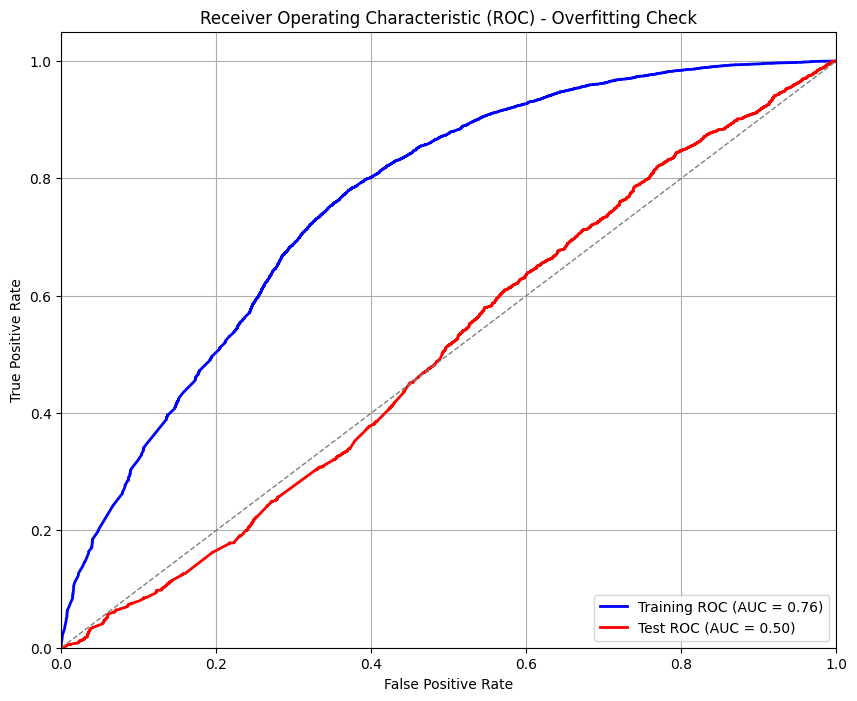

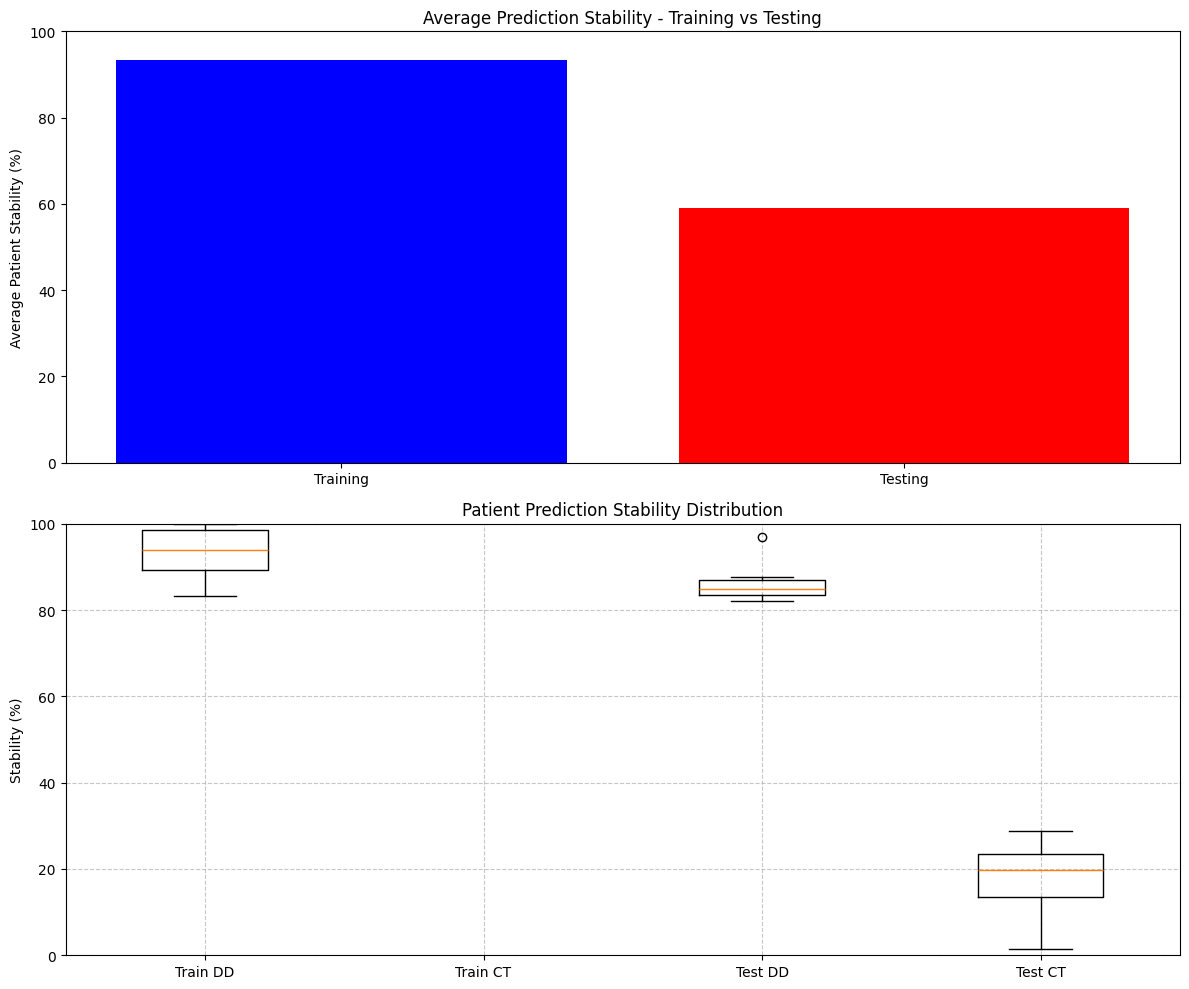

FileExistsError: [Errno 17] File exists: '/home/mario/Python/Datasets/EEG/timeseries/processed/rqa_windows/time_resolved_classification'

In [1]:
# Import the necessary modules
from pyddeeg.classification.engine.trainer import create_model_config, train_model
from pyddeeg.classification.engine.validator import validate_model
from pyddeeg.classification.dataloaders import create_labeled_dataset
from pyddeeg.classification.utils.strat_kfold import stratified_kfold


# Set up paths
DATASET_ROOT = "/home/mario/Python/Datasets/EEG/timeseries/processed/rqa_windows/dataset"
OUTPUT_DIR = "/home/mario/Python/Datasets/EEG/timeseries/processed/rqa_windows/time_resolved_classification"

# Define parameters
window = "window_200"
direction = "up"
electrode = "T7"
fold_index = 0

# Create folds
folds = stratified_kfold(root_path=DATASET_ROOT, n_splits=5, random_state=42, output_file=OUTPUT_DIR)

# Create dataset
dataset = create_labeled_dataset(
    dataset_root=DATASET_ROOT,
    window=window,
    direction=direction,
    electrode=electrode,
    fold_info=folds,
    fold_index=fold_index
)

# Print dataset summary
dataset.summary()

# Create model configuration
model_config = create_model_config(
    model_type="histogram_gbm",
    hyperparameters={
        "learning_rate": 0.1,
        "max_depth": 8,
        "random_state": 42,
        "model_name": f"eeg_gbm_{electrode}_f{window}_{direction}_fold{fold_index}"
    }
)

# Train the model
trained_model, train_metrics = train_model(
    dataset=dataset,
    model_config=model_config,
    output_dir=OUTPUT_DIR,
    plot_training_metrics=True
)

# Validate model
validation_metrics = validate_model(
    model=trained_model,
    dataset=dataset,
    threshold=0.5,  # Can be adjusted to optimize precision/recall trade-off
    output_dir=OUTPUT_DIR,
    plot_results=True,
    electrode_name=electrode
)

# Print key metrics
print(f"Validation accuracy: {validation_metrics['accuracy']:.4f}")